

# <span style="color:#336699">Visualising Z-Scores</span>
<hr style="border:2px solid #0077b9;">
<div style="text-align: left;">
    <a href="https://nbviewer.org/github/swisstopo/topo-satromo/blob/dev-20241209/codegallery/jupyter/Python/stac/stac-introduction.ipynb"><img src="https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg" align="center"/></a>
</div>
   
<br/>

<b>Abstract.</b> This Jupyter Notebook visualises z-scores and explains what they tell you.


<br/>


In [ ]:
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from datetime import datetime, timedelta

## Z-score
Z-scores describe how far from the mean a certain value is and thus indicate how "normal" or "rare" it is.


In [ ]:
# Create x values from -4 to 4 standard deviations
x = np.linspace(-4, 4, 1000)

# Calculate the standard normal distribution (mean=0, std=1)
y = stats.norm.pdf(x, 0, 1)

# Create the plot
plt.figure(figsize=(10, 5))

# Define the color gradient
colors = ['#7d6608', '#d4ac0d', '#f7dc6f', '#f5f5f5', '#7dcea0', '#229954', '#145a32']
# positions = [-3, -2, -1, 0, 1, 2, 3]  # Corresponding x positions for color transitions

# Create custom colormap
cmap = LinearSegmentedColormap.from_list('custom', list(zip(np.linspace(0, 1, len(colors)), colors)))

# Create the gradient fill
for i in range(len(x)-1):
    # Normalize x value to 0-1 range for colormap (mapping -4 to 4 range to 0-1)
    norm_x = (x[i] + 4) / 8  # Convert -4 to 4 range to 0 to 1 range
    color = cmap(norm_x)
    
    # Fill small segment under curve
    plt.fill_between([x[i], x[i+1]], [0, 0], [y[i], y[i+1]], color=color, alpha=0.7)


plt.plot(x, y, 'k-', linewidth=2, label='Standard Normal Distribution')

# Set axis labels
plt.xlabel('Z-Score', fontsize=14)
plt.ylabel('Probability Density', fontsize=14)

# Remove y-axis tick labels
plt.yticks([])

# Set x-axis ticks at standard deviation intervals
plt.xticks(np.arange(-4, 5), ['-4', '-3', '-2', '-1', '0', '1', '2', '3', '4'], fontsize=14)

# Add vertical lines from x-axis to curve at key z-scores
for i in range(-3, 4):
    y_at_i = stats.norm.pdf(i, 0, 1)  # Get y-value on curve at x=i
    plt.plot([i, i], [0, y_at_i], color='gray', linestyle='-', alpha=0.7, linewidth=1)

# Set axis limits
plt.xlim(-4, 4)
plt.ylim(-0.29, 0.42)  # Extended bottom to accommodate arrows

# Create custom arrows for axes
ax = plt.gca()
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Hide the part of y-axis below zero
ax.spines['left'].set_bounds(0, 0.42)  # Only show y-axis from 0 to top
ax.yaxis.set_label_coords(0.5, 0.7)  # Position y-label in middle of positive range

# Add horizontal double-headed arrows with percentages
arrow_y1 = -0.15
arrow_y2 = -0.22
arrow_y3 = -0.29

# 68% arrow (±1σ)
ax.annotate('', xy=(1, arrow_y1), xytext=(-1, arrow_y1),
            arrowprops=dict(arrowstyle='<->', color='black', lw=1))
ax.text(0, arrow_y1 + 0.01, '68%', ha='center', va='bottom', fontsize=14)

# 95% arrow (±2σ)
ax.annotate('', xy=(2, arrow_y2), xytext=(-2, arrow_y2),
            arrowprops=dict(arrowstyle='<->', color='black', lw=1))
ax.text(0, arrow_y2 + 0.01, '95%', ha='center', va='bottom', fontsize=14)

# 99.7% arrow (±3σ)
ax.annotate('', xy=(3, arrow_y3), xytext=(-3, arrow_y3),
            arrowprops=dict(arrowstyle='<->', color='black', lw=1))
ax.text(0, arrow_y3 + 0.01, '99.7%', ha='center', va='bottom', fontsize=14)

# Adjust layout and show
plt.tight_layout()
plt.show()

# Optional: Add some statistical information
print("Key properties of the standard normal distribution:")
print(f"Mean (μ): 0")
print(f"Standard deviation (σ): 1")
print(f"68% of data falls within ±1σ: [{-1:.1f}, {1:.1f}]")
print(f"95% of data falls within ±2σ: [{-2:.1f}, {2:.1f}]")
print(f"99.7% of data falls within ±3σ: [{-3:.1f}, {3:.1f}]")

## Real values from the GEE

In [13]:
import ee
import json
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pydrive.auth import GoogleAuth
from oauth2client.service_account import ServiceAccountCredentials

In [14]:
# GEE credentials
config = r'D:\Users\joan-sturm-w1\Documents\GitHub\topo-satromo\secrets\geetest-credentials-int.secret'

Initialize Google Earth Engine (GEE)

In [15]:
def initialize_gee_and_drive():
    """
    Initializes and authenticates Google Earth Engine (GEE) and Google Drive APIs using service account credentials.
    
    This function:
    1. Sets up authentication scopes for Google Drive
    2. Reads service account key file from the config path
    3. Authenticates with Google Drive using the service account credentials
    4. Initializes Google Earth Engine with the same credentials
    5. Performs a test query to verify GEE initialization was successful
    
    Requirements:
        - PyDrive (for Google Drive authentication)
        - Earth Engine Python API (ee)
        - oauth2client (for ServiceAccountCredentials)
        - Valid service account key file path in config variable
    
    Returns:
        None. Prints confirmation message if initialization was successful or failure message otherwise.
    
    Raises:
        FileNotFoundError: If the service account key file cannot be found
        JSONDecodeError: If the service account key file is not valid JSON
        EEException: If Earth Engine initialization fails
    """
    # Set scopes for Google Drive
    scopes = ["https://www.googleapis.com/auth/drive"]

    # Initialize GEE and authenticate using the service account key file

    # Read the service account key file
    with open(config, "r") as f:
        data = json.load(f)

    # Authenticate with Google using the service account key file
    gauth = GoogleAuth()
    gauth.service_account_file = config
    gauth.service_account_email = data["client_email"]
    gauth.credentials = ServiceAccountCredentials.from_json_keyfile_name(
        gauth.service_account_file, scopes=scopes
    )

    # Initialize Google Earth Engine
    credentials = ee.ServiceAccountCredentials(
        gauth.service_account_email, gauth.service_account_file
    )
    ee.Initialize(credentials)

    # Test if GEE initialization is successful
    image = ee.Image("NASA/NASADEM_HGT/001")
    title = image.get("title").getInfo()

    if title == "NASADEM: NASA NASADEM Digital Elevation 30m":
        print("GEE initialization successful")
    else:
        print("GEE initialization FAILED")

# Authenticate with GEE and GDRIVE
initialize_gee_and_drive()

GEE initialization successful


<hr style="border:1px solid #0077b9;">

### Defining collections, time and other variables:

In [41]:
# Load the warn regions feature and VHI image collections
regions = ee.FeatureCollection('projects/satromo-prod/assets/res/warnregionen_vhi_2056')
ndvi_ref_col = ee.ImageCollection('projects/satromo-prod/assets/col/1991-2020_NDVI_SWISS')
s2_col = ee.ImageCollection('projects/satromo-prod/assets/col/S2_SR_HARMONIZED_SWISS')

In [42]:
# Scale the reference values appropriately
def scale_reference(image):
    """
    Scales the reference image to 0-1 range.
    
    Args:
        image (ee.Image): The input reference image to scale.
        
    Returns:
        ee.Image: The scaled reference image.
    """
    # Get scale and offset from image properties
    scale = ee.Number(image.get('scale'))
    offset = ee.Number(image.get('offset'))
    
    # Scale the 'median' band
    scaled_band = image.select('median').subtract(offset).divide(scale)
    
    return scaled_band.copyProperties(image, image.propertyNames())

# Scale the NDVI reference collection
ndvi_ref_col_scaled = ndvi_ref_col.map(scale_reference)


Defininig the region of interest (ROI) for several options:
1. specific warn region
2. boundary box by coordinates

In [43]:
# 1. specific warn region
region_nr = 34 #[31-68]  
region_feature = regions.filter(ee.Filter.eq('REGION_NR', region_nr)).first()
# Get the region geometry
roi = region_feature.geometry()
roi_name = region_feature.get('Name').getInfo()
print('Region of interest: ' + roi_name)

Region of interest: Berner Mittelland


In [19]:
# 2. boundary box by coordinates

# roi = ee.Geometry.Rectangle([8.06, 47.14, 8.72, 47.18]) # Raten ZG/SZ
# roi_name = 'Raten, ZG/SZ'

# roi = ee.Geometry.Rectangle([6.40, 46.47, 6.81, 46.61]) # Lausanne VD
# roi_name = 'Lausanne, VD'

roi = ee.Geometry.Rectangle([7.37, 46.95, 7.44, 46.97]) # Bremgartenwald, BE
roi_name = 'Bremgartenwald, BE'

print('Region of interest: ' + roi_name)

Region of interest: Bremgartenwald, BE


Combining the ROI with the desired vegetation type:

In [44]:
# Vegetation type: FOREST or ...
vegmask = ee.Image('projects/satromo-prod/assets/res/ch_bafu_lebensraumkarte_mask_forest_epsg32632')
vegmask_name = 'Forest'

# ... all vegetation
# vegmask = ee.Image('projects/satromo-prod/assets/res/ch_bafu_lebensraumkarte_mask_vegetation_epsg32632')
# vegmask_name = 'Vegetation'

# Combining aoi and vegetation mask
veg_mask_roi = vegmask.clip(roi)

Filter the swissEO S2-SR data to a specific year and generate the NDVI values for that year:


In [45]:
# Filter Sentinel-2 SR data
def filter_s2_col_and_add_ndsi(image_collection, year, roi):
    """
    Filters the Sentinel-2 image collection by date and region of interest (ROI),
    and separates the collection into 10m and 20m resolution images.
    
    Args:
        image_collection (ee.ImageCollection): The input Sentinel-2 image collection.
        year (num): The year for filtering.
        roi (ee.Geometry): The region of interest for spatial filtering.
        
    Returns:
        A ee.ImageCollection: s2_col_10m: Filtered collection with 10m resolution images containing added ndsi band.
    """
    start_date = f'{year}-01-01'
    end_date_filter = f'{year+1}-01-01'

    s2_col_10m = ee.ImageCollection(image_collection) \
        .filterDate(start_date, end_date_filter) \
        .filterBounds(roi) \
        .filter(ee.Filter.stringEndsWith('system:index', '10m'))

    s2_col_20m = ee.ImageCollection(image_collection) \
            .filterDate(start_date, end_date_filter) \
            .filterBounds(roi) \
            .filter(ee.Filter.stringEndsWith('system:index', '20m'))
    
    # Function to calculate NDSI
    def create_ndsi_mapper(image_20m_collection):
        def add_ndsi(image_10m):
            # Get the acquisition date of the current image
            acq_date = image_10m.get('system:time_start')
            
            # Filter the 20m collection for matching date
            swir_image = image_20m_collection.filter(ee.Filter.eq('system:time_start', acq_date)).first()
            
            # Select bands
            green = image_10m.select('B3')
            swir = swir_image.select('B11')
            
            # Calculate NDSI
            ndsi = green.subtract(swir).divide(green.add(swir)).rename('ndsi')
            
            return image_10m.addBands(ndsi)
        
        return add_ndsi
    
    ndsi_mapper = create_ndsi_mapper(s2_col_20m)
    s2_col = s2_col_10m.map(ndsi_mapper)

    return s2_col

# Calculate NDVI for each image in the collection
def calculate_ndvi(image):
    """
    Calculates NDVI for a given Sentinel-2 image.
    
    Args:
        image (ee.Image): The input Sentinel-2 image.
        
    Returns:
        ee.Image: The image with an added NDVI band.
    """
    # Apply the cloud and terrain shadow mask within the S2 image collection
    image_masked = image.updateMask(image.select('terrainShadowMask').lt(65))
    image_masked = image_masked.updateMask(image.select('cloudAndCloudShadowMask').eq(0))
    image_masked = image_masked.updateMask(image.select('ndsi').lt(0.43))

    # Calculate NDVI
    ndvi = image_masked.normalizedDifference(['B8', 'B4']).rename('NDVI')
    
    # Add the NDVI band to the image
    return image.addBands(ndvi)

In [59]:
s2_col_2017 = filter_s2_col_and_add_ndsi(s2_col, 2017, roi)
ndvi_col_2017 = s2_col_2017.map(calculate_ndvi)

s2_col_2018 = filter_s2_col_and_add_ndsi(s2_col, 2018, roi)
ndvi_col_2018 = s2_col_2018.map(calculate_ndvi)

s2_col_2019 = filter_s2_col_and_add_ndsi(s2_col, 2019, roi)
ndvi_col_2019 = s2_col_2019.map(calculate_ndvi)

s2_col_2020 = filter_s2_col_and_add_ndsi(s2_col, 2020, roi)
ndvi_col_2020 = s2_col_2020.map(calculate_ndvi)

s2_col_2021 = filter_s2_col_and_add_ndsi(s2_col, 2021, roi)
ndvi_col_2021 = s2_col_2021.map(calculate_ndvi)

s2_col_2022 = filter_s2_col_and_add_ndsi(s2_col, 2022, roi)
ndvi_col_2022 = s2_col_2022.map(calculate_ndvi)

s2_col_2023 = filter_s2_col_and_add_ndsi(s2_col, 2023, roi)
ndvi_col_2023 = s2_col_2023.map(calculate_ndvi)

s2_col_2024 = filter_s2_col_and_add_ndsi(s2_col, 2024, roi)
ndvi_col_2024 = s2_col_2024.map(calculate_ndvi)

s2_col_2025 = filter_s2_col_and_add_ndsi(s2_col, 2025, roi)
ndvi_col_2025 = s2_col_2025.map(calculate_ndvi)

Get the median NDVI value for the defined roi and filling it into an data frame

In [47]:
def extract_ndvi_timeseries(image_collection, vegetation_mask, ndvi_band='NDVI', scale=10):
    """
    Extract median NDVI values within a vegetation mask for each image in a collection.
    
    Parameters:
    -----------
    image_collection : ee.ImageCollection
        Collection of images containing NDVI band
    vegetation_mask : ee.Image
        Binary mask (1 for vegetation, 0 for non-vegetation)
    ndvi_band : str, default 'NDVI'
        Name of the NDVI band in the image collection
    scale : int, default 10
        Scale in meters for the reduction operation (default is 10m for Sentinel-2)
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame with columns 'doy' and 'median_ndvi'
    """
    
    def calculate_median_ndvi(image):
        """Calculate median NDVI within vegetation mask for a single image."""
        # Apply the vegetation mask to the NDVI band
        ndvi_masked = image.select(ndvi_band).updateMask(vegetation_mask)
        
        # Calculate median NDVI within the masked area
        median_ndvi_dict = ndvi_masked.reduceRegion(
            reducer=ee.Reducer.median(),
            geometry=vegetation_mask.geometry(),
            scale=scale,
            maxPixels=1e9,
            bestEffort=True
        )
        
        # Get the day of year from the image
        doy = image.date().getRelative('day', 'year').add(1)  # Add 1 to start from day 1
        
        # Extract the NDVI value from the dictionary
        median_ndvi_value = median_ndvi_dict.get(ndvi_band)
        
        # Return a feature with the results
        return ee.Feature(None, {
            'doy': doy,
            'median_ndvi': median_ndvi_value
        })
    
    # Map the function over the image collection
    features = image_collection.map(calculate_median_ndvi)
    
    # Convert to a list and get the info
    feature_list = features.getInfo()
    
    # Extract the data into lists
    doy_list = []
    ndvi_list = []
    
    for feature in feature_list['features']:
        properties = feature['properties']
        doy = properties.get('doy')
        median_ndvi = properties.get('median_ndvi')
        
        # Only add valid entries (skip if NDVI is None/null)
        if doy is not None and median_ndvi is not None:
            doy_list.append(doy)
            ndvi_list.append(median_ndvi)
        # else:
        #     print(f"Warning: Skipping entry with DOY={doy}, NDVI={median_ndvi}")
    
    # Create DataFrame
    df = pd.DataFrame({
        'doy': doy_list,
        'median_ndvi': ndvi_list
    })
    
    # Sort by day of year
    df = df.sort_values('doy').reset_index(drop=True)
    
    return df

In [60]:
# Apply the function to the NDVI collection
df_2017 = extract_ndvi_timeseries(ndvi_col_2017, veg_mask_roi)
df_2018 = extract_ndvi_timeseries(ndvi_col_2018, veg_mask_roi)
df_2019 = extract_ndvi_timeseries(ndvi_col_2019, veg_mask_roi)
df_2020 = extract_ndvi_timeseries(ndvi_col_2020, veg_mask_roi)
df_2021 = extract_ndvi_timeseries(ndvi_col_2021, veg_mask_roi)
df_2022 = extract_ndvi_timeseries(ndvi_col_2022, veg_mask_roi)
df_2023 = extract_ndvi_timeseries(ndvi_col_2023, veg_mask_roi)
df_2024 = extract_ndvi_timeseries(ndvi_col_2024, veg_mask_roi)
df_2025 = extract_ndvi_timeseries(ndvi_col_2025, veg_mask_roi)

# Display the results
print("NDVI Time Series for 2023:")
print(df_2023.head(7))

NDVI Time Series for 2023:
   doy  median_ndvi
0   19     0.316482
1   29     0.513429
2   34     0.722606
3   39     0.564481
4   44     0.707029
5   49     0.582013
6   54     0.511704


Reference period: NDVI values and their std

In [50]:
def extract_ndvi_timeseries_ref(image_collection, vegetation_mask, ndvi_band='median', scale=30):
    """
    Extract median NDVI values within a vegetation mask for each image in a collection.
    
    Parameters:
    -----------
    image_collection : ee.ImageCollection
        Collection of images containing NDVI statistics band
    vegetation_mask : ee.Image
        Binary mask (1 for vegetation, 0 for non-vegetation)
    ndvi_band : str, default 'median'
        Name of the NDVI median values band in the image collection
    scale : int, default 30
        Scale in meters for the reduction operation (default is 30m for Landsat data)
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame with columns 'doy' and 'median_ndvi'
    """
    
    def calculate_median_ndvi(image):
        """Calculate median NDVI within vegetation mask for a single image."""
        # Apply the vegetation mask to the NDVI band
        ndvi_masked = image.select(ndvi_band).updateMask(vegetation_mask)
        
        # Calculate median NDVI within the masked area
        ndvi_stats_dict = ndvi_masked.reduceRegion(
            reducer=ee.Reducer.median().combine(
                reducer2=ee.Reducer.stdDev(),
                sharedInputs=True
            ),
            geometry=vegetation_mask.geometry(),
            scale=scale,
            maxPixels=1e9,
            bestEffort=True
        )
        
        # Get the day of year from the image
        doy = image.get('doy')
        
        # Extract the NDVI value from the dictionary
        median_ndvi_value = ndvi_stats_dict.get(ndvi_band + '_median')
        std_ndvi_value = ndvi_stats_dict.get(ndvi_band + '_stdDev')
        
        # Return a feature with the results
        return ee.Feature(None, {
            'doy': doy,
            'median_ndvi': median_ndvi_value,
            'std_ndvi': std_ndvi_value
        })
    
    # Map the function over the image collection
    features = image_collection.map(calculate_median_ndvi)
    
    # Convert to a list and get the info
    feature_list = features.getInfo()
    
    # Extract the data into lists
    doy_list = []
    ndvi_list = []
    std_list = []
    
    for feature in feature_list['features']:
        properties = feature['properties']
        doy = properties.get('doy')
        median_ndvi = properties.get('median_ndvi')
        std_ndvi = properties.get('std_ndvi')
        
        # Only add valid entries (skip if NDVI is None/null)
        if doy is not None and median_ndvi is not None:
            doy_list.append(doy)
            ndvi_list.append(median_ndvi)
            std_list.append(std_ndvi)
        # else:
        #     print(f"Warning: Skipping entry with DOY={doy}, NDVI={median_ndvi}")
    
    # Create DataFrame
    df = pd.DataFrame({
        'doy': doy_list,
        'median_ndvi': ndvi_list,
        'std_ndvi': std_list
    })
    
    # Sort by day of year
    df = df.sort_values('doy').reset_index(drop=True)
    
    return df

In [51]:
df_ref = extract_ndvi_timeseries_ref(ndvi_ref_col_scaled, veg_mask_roi)
# Display the results
print("NDVI Time Series for the reference period 1991-2020:")
print(df_ref.head(7))

NDVI Time Series for the reference period 1991-2020:
   doy  median_ndvi  std_ndvi
0    0         0.60  0.176716
1    1         0.59  0.179496
2    2         0.60  0.169676
3    3         0.60  0.169696
4    4         0.61  0.169071
5    5         0.60  0.172022
6    6         0.59  0.174090


Calculate z-score for the NDVI values:

In [52]:
def calculate_ndvi_zscores(yearly_df, reference_df):
    """
    Calculate z-scores for yearly NDVI data using reference statistics.
    
    Parameters:
    -----------
    yearly_df : pandas.DataFrame
        DataFrame with columns 'doy' and 'median_ndvi' for a specific year
    reference_df : pandas.DataFrame
        Reference DataFrame with columns 'doy', 'median_ndvi', and 'std_ndvi'
    
    Returns:
    --------
    pandas.DataFrame
        Original yearly DataFrame with added 'ndvi_zscore' column
    """
    
    # Create a copy to avoid modifying the original dataframe
    result_df = yearly_df.copy()
    
    # Create a dictionary for fast lookup of reference values by DOY
    ref_dict = {}
    for _, row in reference_df.iterrows():
        ref_dict[row['doy']] = {
            'ref_median': row['median_ndvi'],
            'ref_std': row['std_ndvi']
        }
    
    # Calculate z-scores for each row
    zscore_list = []
    
    for _, row in result_df.iterrows():
        doy = row['doy']
        observed_ndvi = row['median_ndvi']
        
        # Check if we have reference data for this DOY
        if doy in ref_dict:
            ref_median = ref_dict[doy]['ref_median']
            ref_std = ref_dict[doy]['ref_std']
            
            # Calculate z-score: (observed - reference_mean) / reference_std
            if ref_std > 0:  # Avoid division by zero
                zscore = (observed_ndvi - ref_median) / ref_std
            else:
                zscore = np.nan  # Set to NaN if std is 0
                print(f"Warning: Standard deviation is 0 for DOY {doy}")
        else:
            zscore = np.nan  # Set to NaN if no reference data available
            print(f"Warning: No reference data available for DOY {doy}")
        
        zscore_list.append(zscore)
    
    # Add the z-score column
    result_df['ndvi_zscore'] = zscore_list
    
    return result_df

In [61]:
df_2017_with_zscores = calculate_ndvi_zscores(df_2017, df_ref)
df_2018_with_zscores = calculate_ndvi_zscores(df_2018, df_ref)
df_2019_with_zscores = calculate_ndvi_zscores(df_2019, df_ref)
df_2020_with_zscores = calculate_ndvi_zscores(df_2020, df_ref)
df_2021_with_zscores = calculate_ndvi_zscores(df_2021, df_ref)
df_2022_with_zscores = calculate_ndvi_zscores(df_2022, df_ref)
df_2023_with_zscores = calculate_ndvi_zscores(df_2023, df_ref)
df_2024_with_zscores = calculate_ndvi_zscores(df_2024, df_ref)
df_2025_with_zscores = calculate_ndvi_zscores(df_2025, df_ref)

print("NDVI Time Series for 2023 with Z-Scores:")
print(df_2023_with_zscores.head(7))

NDVI Time Series for 2023 with Z-Scores:
   doy  median_ndvi  ndvi_zscore
0   19     0.316482    -1.154549
1   29     0.513429     0.091208
2   34     0.722606     1.467867
3   39     0.564481     0.321603
4   44     0.707029     1.486190
5   49     0.582013     0.421328
6   54     0.511704    -0.069853


## Plotting the NDVI and their z-score values:

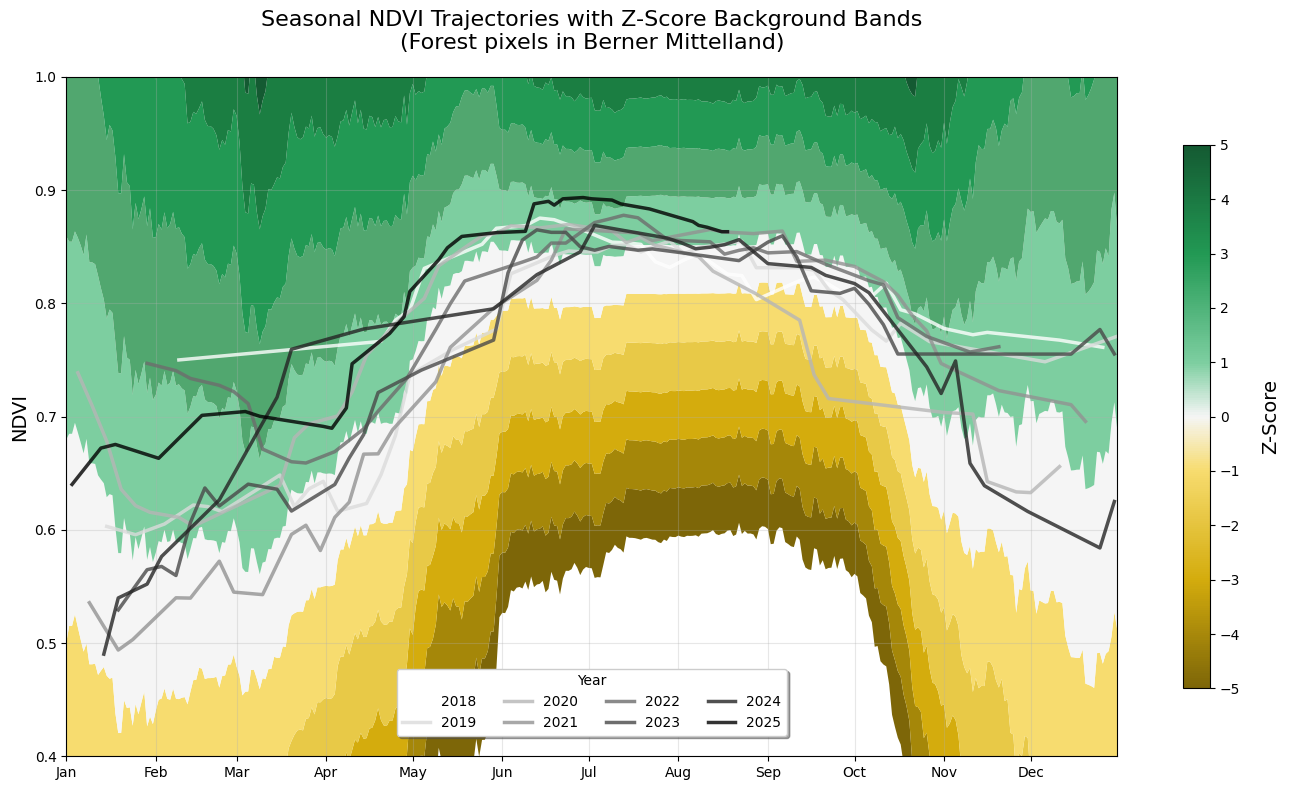

In [ ]:
# Define z-score color mapping (same as your original)
z_colors = {
    -5: '#7d6608',
    -3: '#d4ac0d',
    -1: '#f7dc6f',
    0: '#f5f5f5',
    1: '#7dcea0',
    3: '#229954',
    5: '#145a32'
}

# Create colormap from the z-score colors
z_values = sorted(z_colors.keys())
colors = [z_colors[z] for z in z_values]
normalized_positions = [(z + 5) / 10 for z in z_values]  # Convert -5 to 5 range to 0 to 1
cmap = mcolors.LinearSegmentedColormap.from_list(
    'z_score_cmap',
    list(zip(normalized_positions, colors))
)

# Define your yearly dataframes dictionary (adjust variable names as needed)
yearly_dfs = {
    # 2017: df_2017_with_zscores, 
    2018: df_2018_with_zscores,
    2019: df_2019_with_zscores,
    2020: df_2020_with_zscores,
    2021: df_2021_with_zscores,
    2022: df_2022_with_zscores,
    2023: df_2023_with_zscores,
    2024: df_2024_with_zscores,
    2025: df_2025_with_zscores
}

# Create the plot
fig, ax = plt.subplots(figsize=(14, 8))

# First, create the background z-score bands using df_ref
z_bands = [
    (-5.5, -4.5, '#7d6608'),
    (-4.5, -3.5, '#a58709'),
    (-3.5, -2.5, '#d4ac0d'), 
    (-2.5, -1.5, '#e8c947'),
    (-1.5, -0.5, '#f7dc6f'),
    (-0.5, 0.5, '#f5f5f5'),
    (0.5, 1.5, '#7dcea0'),
    (1.5, 2.5, '#51a76f'),
    (2.5, 3.5, '#229954'),
    (3.5, 4.5, '#1b7e42'),
    (4.5, 5.5, '#145a32')
]

# Convert z-scores to NDVI space for background bands using df_ref
doy_range = np.linspace(1, 365, 365)

for z_min, z_max, color in z_bands:
    ndvi_min_band = []
    ndvi_max_band = []
    
    for doy in doy_range:
        # Find the closest DOY in your reference data
        closest_doy_idx = np.argmin(np.abs(df_ref['doy'] - doy))
        
        # Get the mean and std for this DOY from df_ref
        mean_ndvi = df_ref.iloc[closest_doy_idx]['median_ndvi']
        std_ndvi = df_ref.iloc[closest_doy_idx]['std_ndvi']
        
        # Handle NaN values
        if np.isnan(mean_ndvi) or np.isnan(std_ndvi):
            ndvi_min_band.append(np.nan)
            ndvi_max_band.append(np.nan)
            continue
        
        # Convert z-scores to NDVI values
        ndvi_min = mean_ndvi + z_min * std_ndvi
        ndvi_max = mean_ndvi + z_max * std_ndvi
        
        ndvi_min_band.append(ndvi_min)
        ndvi_max_band.append(ndvi_max)
    
    # Fill between the z-score bands
    ax.fill_between(doy_range, ndvi_min_band, ndvi_max_band, 
                   color=color, alpha=1, edgecolor='none')

# Define line styles for different years (all in same dark grey color)
years = sorted(yearly_dfs.keys())
n_years = len(years)
line_styles = ['-', '--', '-.', ':', '-', '--', '-.', ':'] 
dark_grey = '#404040'  # Dark grey color for all lines

# Plot individual year trajectories
for i, (year, df) in enumerate(sorted(yearly_dfs.items())):
    # Skip if dataframe is empty or has no valid data
    if df.empty:
        print(f"Warning: No data for year {year}")
        continue
    
    # Get NDVI values and DOY for this year
    year_doy = df['doy'].values
    year_ndvi = df['median_ndvi'].values
    
    # Remove NaN values
    valid_mask = ~np.isnan(year_ndvi)
    if np.sum(valid_mask) == 0:
        print(f"Warning: No valid NDVI data for year {year}")
        continue
        
    clean_doy = year_doy[valid_mask]
    clean_ndvi = year_ndvi[valid_mask]
    
    # Sort by DOY to ensure proper order
    sort_idx = np.argsort(clean_doy)
    clean_doy = clean_doy[sort_idx]
    clean_ndvi = clean_ndvi[sort_idx]
    
    # Apply 7-day moving average using pandas rolling window
    ndvi_series = pd.Series(clean_ndvi, index=clean_doy)
    smoothed_ndvi = ndvi_series.rolling(window=7, center=True, min_periods=1).mean()
    
    # Plot the line for this year
    ax.plot(smoothed_ndvi.index, smoothed_ndvi.values, 
           color=dark_grey, linewidth=2.5, alpha=0.8, 
           linestyle=line_styles[i], label=f'{year}')

# Function to convert DOY to month label
def doy_to_month_label(doy):
    """Convert DOY to month label"""
    date = datetime(2023, 1, 1) + timedelta(days=int(doy) - 1)
    return date.strftime('%b')

# Set x-axis ticks and labels
month_doys = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
month_labels = [doy_to_month_label(doy) for doy in month_doys]
ax.set_xticks(month_doys)
ax.set_xticklabels(month_labels)
ax.set_xlim(1, 365)
ax.set_ylim(0.4, 1)

# Create a custom colorbar for the z-score bands
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-5, vmax=5))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
cbar.set_label('Z-Score', fontsize=14, labelpad=15)

# Add z-score labels on the colorbar
cbar.set_ticks([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])

# Add legend for the year lines
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 0.02), 
         title='Year', frameon=True, fancybox=True, shadow=True,
         ncol=4)  # Display legend in 4 columns to save space

# Customize the plot
ax.set_ylabel('NDVI', fontsize=14)
ax.set_title('Seasonal NDVI Trajectories with Z-Score Background Bands\n(Forest pixels in ' + roi_name + ')',
            fontsize=16, pad=20)

# Add grid
ax.grid(True, alpha=0.3, zorder=0)

plt.tight_layout()
plt.show()

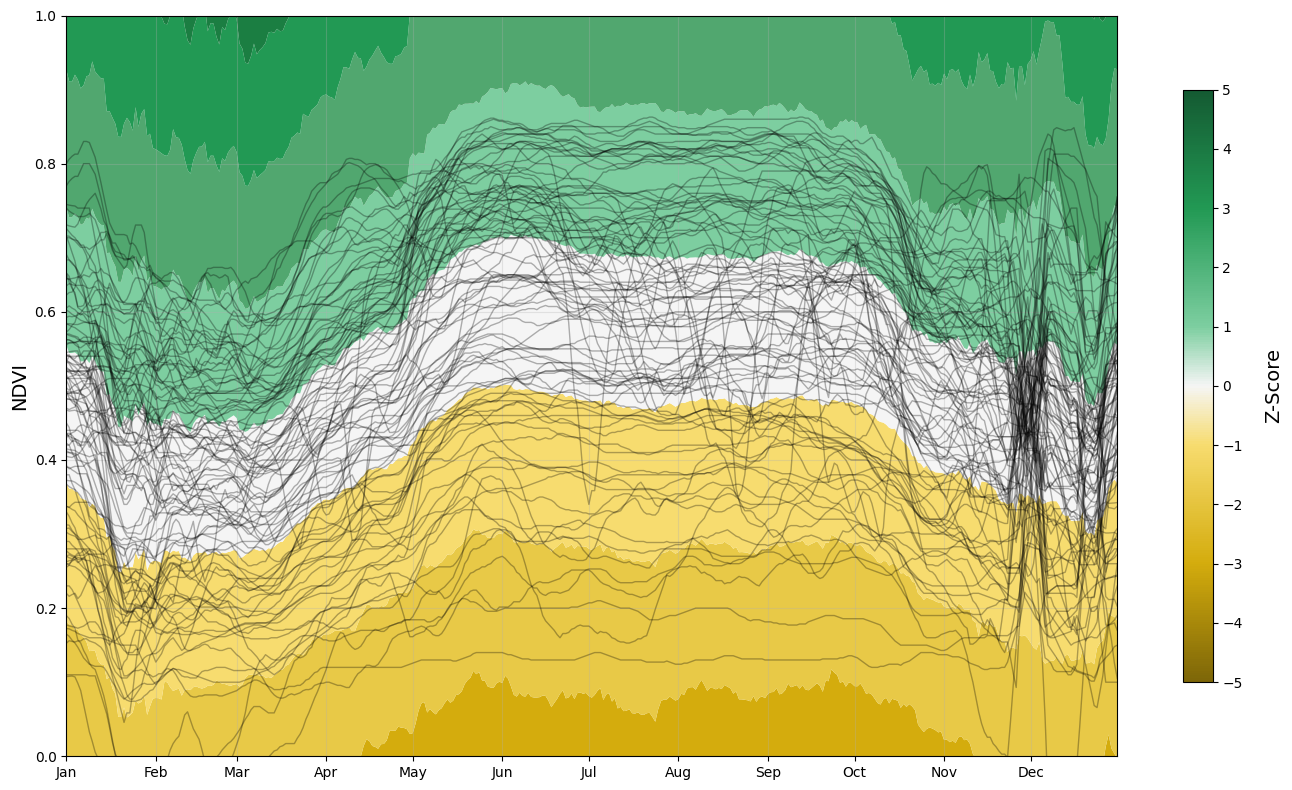

In [ ]:
# Define z-score color mapping
z_colors = {
    -5: '#7d6608',
    -3: '#d4ac0d',
    -1: '#f7dc6f',
    0: '#f5f5f5',
    1: '#7dcea0',
    3: '#229954',
    5: '#145a32'
}

# Create colormap from the z-score colors
z_values = sorted(z_colors.keys())
colors = [z_colors[z] for z in z_values]
normalized_positions = [(z + 5) / 10 for z in z_values]  # Convert -5 to 5 range to 0 to 1
cmap = mcolors.LinearSegmentedColormap.from_list(
    'z_score_cmap',
    list(zip(normalized_positions, colors))
)

# Get sample columns
sample_columns = [col for col in ndvi_ref_df.columns if col.startswith('sample_')]

# Create the plot
fig, ax = plt.subplots(figsize=(14, 8))

# First, create the background z-score bands
# Define the z-score bands (you can adjust these ranges as needed)
z_bands = [
    (-5.5, -4.5, '#7d6608'),
    (-4.5, -3.5, '#a58709'),
    (-3.5, -2.5, '#d4ac0d'), 
    (-2.5, -1.5, '#e8c947'),
    (-1.5, -0.5, '#f7dc6f'),
    (-0.5, 0.5, '#f5f5f5'),
    (0.5, 1.5, '#7dcea0'),
    (1.5, 2.5, '#51a76f'),
    (2.5, 3.5, '#229954'),
    (3.5, 4.5, '#1b7e42'),
    (4.5, 5.5, '#145a32')
]

# Convert z-scores to NDVI space for background bands
# We'll create bands across the full DOY range
doy_range = np.linspace(1, 365, 365)

# For each z-score band, we need to convert to NDVI values
# This requires calculating what NDVI values correspond to each z-score at each DOY
for z_min, z_max, color in z_bands:
    ndvi_min_band = []
    ndvi_max_band = []
    
    for doy in doy_range:
        # Find the closest DOY in your reference data
        closest_doy_idx = np.argmin(np.abs(ndvi_ref_df['doy'] - doy))
        
        # Get the mean and std for this DOY across all pixels
        ndvi_values_doy = ndvi_ref_df.iloc[closest_doy_idx][sample_columns].values
        z_values_doy = z_score_ref_df.iloc[closest_doy_idx][sample_columns].values
        
        # Remove any NaN values
        valid_mask = ~(np.isnan(ndvi_values_doy) | np.isnan(z_values_doy))
        if np.sum(valid_mask) == 0:
            ndvi_min_band.append(np.nan)
            ndvi_max_band.append(np.nan)
            continue
            
        ndvi_clean = ndvi_values_doy[valid_mask]
        z_clean = z_values_doy[valid_mask]
        
        # Calculate mean and std for this DOY
        mean_ndvi = np.mean(ndvi_clean)
        std_ndvi = np.std(ndvi_clean)
        
        # Convert z-scores to NDVI values
        ndvi_min = mean_ndvi + z_min * std_ndvi
        ndvi_max = mean_ndvi + z_max * std_ndvi
        
        ndvi_min_band.append(ndvi_min)
        ndvi_max_band.append(ndvi_max)
    
    # Fill between the z-score bands
    ax.fill_between(doy_range, ndvi_min_band, ndvi_max_band, 
                   color=color, alpha=1, edgecolor='none')

# Now plot individual pixel trajectories as smoothed lines
for sample_col in sample_columns:
    # Get NDVI values for this pixel across all DOYs
    pixel_ndvi = ndvi_ref_df[sample_col].values
    pixel_doy = ndvi_ref_df['doy'].values
    
    # Remove NaN values
    valid_mask = ~np.isnan(pixel_ndvi)
    if np.sum(valid_mask) > 7:  # Need enough points for smoothing
        clean_doy = pixel_doy[valid_mask]
        clean_ndvi = pixel_ndvi[valid_mask]
        
        # Sort by DOY to ensure proper order
        sort_idx = np.argsort(clean_doy)
        clean_doy = clean_doy[sort_idx]
        clean_ndvi = clean_ndvi[sort_idx]
        
        # Apply 7-day moving average using pandas rolling window
        # Convert to pandas Series for easy rolling window
        ndvi_series = pd.Series(clean_ndvi, index=clean_doy)
        
        # Apply rolling mean with 7-day window, centered
        smoothed_ndvi = ndvi_series.rolling(window=7, center=True, min_periods=1).mean()
        
        ax.plot(smoothed_ndvi.index, smoothed_ndvi.values, 
               color='black', alpha=0.3, linewidth=1)

# Customize x-axis to show months
def doy_to_month_label(doy):
    """Convert DOY to month label"""
    date = datetime(2023, 1, 1) + timedelta(days=int(doy) - 1)
    return date.strftime('%b')

# Set x-axis ticks and labels
month_doys = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
month_labels = [doy_to_month_label(doy) for doy in month_doys]
ax.set_xticks(month_doys)
ax.set_xticklabels(month_labels)
ax.set_xlim(1, 365)
ax.set_ylim(0, 1)

# Create a custom colorbar for the z-score bands
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-5, vmax=5))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
cbar.set_label('Z-Score', fontsize=14, labelpad=15)

# Add z-score labels on the colorbar
cbar.set_ticks([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])

# Customize the plot
ax.set_ylabel('NDVI', fontsize=14)
ax.set_title('Seasonal NDVI Trajectories with Z-Score Background Bands\n(Forest pixels in ' + roi_name + ')',
            fontsize=16, pad=20)

# Add grid
ax.grid(True, alpha=0.3, zorder=0)

# Add legend explaining the visualization
# legend_text = ('Background bands: Z-score ranges\n'
#                'Black lines: Individual pixel trajectories\n'
#                'Line opacity indicates density of trajectories')
# ax.text(0.02, 0.98, legend_text, transform=ax.transAxes,
#         verticalalignment='top', fontsize=10,
#         bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

plt.tight_layout()
plt.show()